# Practica 2

In [1]:
import nltk
import pickle
import numpy as np
from unidecode import unidecode
from matplotlib import pyplot as plt
from nltk.stem.snowball import SnowballStemmer
#nltk.download('punkt')
%matplotlib inline

In [2]:
with open('corpusML.txt', 'r') as f:
    corpus = f.readlines()

In [3]:
corpus = [unidecode(line.lower()) for line in corpus]

In [4]:
corpus[0:2]

['comence a trabajar y me pegaron, me maltrataron con chicote \n',
 'mis patrones me pegaron porque no me queria apurar, porque era flojo \n']

### 1, 2) Limpiar corpus y agregar simbolos de inicio y fin

* Se limpia el corpus mediante el algoritmo de Porter para el lenguaje español. 
* A cada oracion del corpus, se le agrega el simbolo de inicio y fin. 
* Se crea el alfabeto $\Sigma$ del corpus donde se almacenen unicamente los tipos 

In [6]:
stemmer = SnowballStemmer("spanish")
stems = []                                              # Lista de stems por cada oracion
cleanedCorpus = []                                      # Corpus procesado con stemming
Sigma = []                                              # Alfabeto del corpus (tipos)               

for sentence in corpus:
    tokens = nltk.word_tokenize(sentence)               # Obtener lista tokens
    for tk in tokens:   
        if tk.isalpha():                                # Validar token como caracter del alfabeto                                
            stem = stemmer.stem(tk)                     # Aplicar algotimo de stemming
            stems.append(stem)                          
            if stem not in Sigma:                      
                Sigma.append(stem)
    s = '<BOS> ' + ' '.join(stems) + ' <EOS>'           # Agregar simbolos de inicio y fin
    cleanedCorpus.append(s)                             # Agregar oracion procesada a la lista del corpus limpio                               
    stems.clear()

# Agregar simbolos de inicio y fin al alfabeto
Sigma.append('<BOS>')
Sigma.append('<EOS>')

In [7]:
cleanedCorpus[:3]

['<BOS> comenc a trabaj y me peg me maltrat con chicot <EOS>',
 '<BOS> mis patron me peg porqu no me queri apur porqu era floj <EOS>',
 '<BOS> por eso me habi peg <EOS>']

In [8]:
Sigma[-10:]

['cab',
 'bebecit',
 'tabiqu',
 'calent',
 'pajuel',
 'vapor',
 'quemart',
 'cai',
 '<BOS>',
 '<EOS>']

### 3) Obtener los bigramas

In [9]:
def bigrams(sequence):
    s = sequence.split()
    return [(wi, wj) for wi, wj in zip(s[:-1], s[1:])]

In [10]:
# Obtener los bigramas del corpus limpio
sentence_bigrams = [bigrams(s) for s in cleanedCorpus]

In [11]:
sentence_bigrams[0]

[('<BOS>', 'comenc'),
 ('comenc', 'a'),
 ('a', 'trabaj'),
 ('trabaj', 'y'),
 ('y', 'me'),
 ('me', 'peg'),
 ('peg', 'me'),
 ('me', 'maltrat'),
 ('maltrat', 'con'),
 ('con', 'chicot'),
 ('chicot', '<EOS>')]

In [12]:
# Bigramas de todo el corpus
corpus_bigrams = [bigram for sentence in sentence_bigrams for bigram in sentence]

In [13]:
# Obtener los vectores one hot de cada palabra en el corpus
oneHotMatrix = np.identity(len(Sigma))

In [14]:
word2oneHot = {}        # Entrada: palabra del alfabeto, Salida: vector one hot
word2number = {}        # Entrada: palabra del alfabeto, Salida: indice en la lista del alfabeto
oneHot2word = {}        # Entrada: vector one hot (caracteres), Salida: palabra del alfabeto

for i, (word, vector) in enumerate(zip(Sigma, oneHotMatrix)):
    word2oneHot[word] = vector
    word2number[word] = i
    oneHot2word[np.where(vector==1)[0][0]] = word

In [15]:
word2oneHot['<EOS>']

array([0., 0., 0., ..., 0., 0., 1.])

In [16]:
word2number['<EOS>']

1215

### 4) Entrenar la red neuronal con los bigramas

Dados los bigramas del corpus $(w_i, w_j)$, la red neuronal word2vec es entrenada tomando como entrada y salida a la representacion vectorial *one hot encoded* de la palabra $w_i$ y la palabra $w_j$ respectivamente.

In [17]:
class word2vec():
    def __init__(self, d, N, weights):
        if weights:
            self.U = weights[0]
            self.W = weights[1]
        else:
            self.U = np.random.randn(d, N)*np.sqrt(1/(d+N)) 
            self.W = np.random.randn(N, d)*np.sqrt(1/(d+N)) 
            
    def softmax(self, x):
        exp = np.exp(x-np.max(x))
        return np.divide(exp, np.sum(exp))
    
    def predict(self, x):
        h = np.dot(self.U, x)
        a = np.dot(self.W, h)
        return self.softmax(a)
    
    def fit(self, bigrams, lr, epochs):
        lossWi = []
        loss = []
        for epoch in range(epochs):
            for k, (wi, wj) in enumerate(bigrams):
                x = word2oneHot[wi]
                y = word2oneHot[wj]
                # Feedforward
                h = self.U[:, np.where(x==1)[0][0]]
                a = self.softmax(np.dot(self.W, h))
                # Calcular error
                error = a - y
                # ---- Calcular funcion de perdida ----
                lossWi.append(np.log(a[np.where(y==1)[0][0]]+0.0000000000001))
                if k == len(bigrams)-1:
                    loss.append(-np.sum(lossWi))
                    lossWi.clear()
                    print('EPOCH ({}) = {}'.format(epoch+1, loss[epoch]))
                # -------------------------------------
                # Backpropragation
                dW = np.outer(error, h)
                self.W -= lr*dW
                dU = np.dot(self.W.T, error)
                self.U[:, np.where(x==1)[0][0]] -= lr*dU
        return loss

In [18]:
w2v = word2vec(300, len(Sigma), None)

In [ ]:
%%time
err = w2v.fit(corpus_bigrams, 0.001, 100)

EPOCH (1) = 88288.10368198364
EPOCH (2) = 85038.10596235638
EPOCH (3) = 81512.13781314876
EPOCH (4) = 77543.75249367247
EPOCH (5) = 73445.02697879684
EPOCH (6) = 70067.39485566267
EPOCH (7) = 67465.73981033766
EPOCH (8) = 65340.72903615939
EPOCH (9) = 63530.147974573236
EPOCH (10) = 61943.68429566639
EPOCH (11) = 60567.47221742553
EPOCH (12) = 59377.40178469819
EPOCH (13) = 58346.58790664731
EPOCH (14) = 57446.01686674188
EPOCH (15) = 56643.859373019804
EPOCH (16) = 55914.633279900176
EPOCH (17) = 55241.21941755677
EPOCH (18) = 54613.415030883065
EPOCH (19) = 54025.42809253452
EPOCH (20) = 53473.80039028346
EPOCH (21) = 52955.05735191031
EPOCH (22) = 52464.74890822822
EPOCH (23) = 51998.5740165076
EPOCH (24) = 51553.41494674146
EPOCH (25) = 51127.419951420816
EPOCH (26) = 50719.68777796246
EPOCH (27) = 50329.923237581446
EPOCH (28) = 49957.9036116905
EPOCH (29) = 49602.859088788435
EPOCH (30) = 49263.553887862996
EPOCH (31) = 48938.91178020158
EPOCH (32) = 48628.29223342652
EPOCH (33) 

In [0]:
# Guardar parametros de la red
with open(path + 'weights.pickle', 'wb') as file:
    pickle.dump([w2v.U, w2v.W, err], file)

In [0]:
# Leer el archivo con los parametros
# y verificar que sean correctos
with open(path + 'weights.pickle', 'rb') as file:
    U, W, err = pickle.load(file)

In [0]:
# Prueba de prediccion
word = 'las'
wordVector = word2oneHot[stemmer.stem(word)]
pred = predict(wordVector)
print('Suma = ', np.sum(pred))                    # Suma para verificar que sea igual a 1
indice = np.argmax(pred)                          # Indice de la palabra con mayor probilidad
word_predicted = oneHot2word[indice] 

print('Indice palabra pred = ', indice)
print('Prediccion = ', word_predicted)
print('P({}|{}) = {}'.format(word_predicted, word, pred[indice]))
print(word + ' ' + word_predicted)

Suma =  1.0000000000000002
Indice palabra pred =  148
Prediccion =  dos
P(dos|las) = 0.06175388656226358
las dos


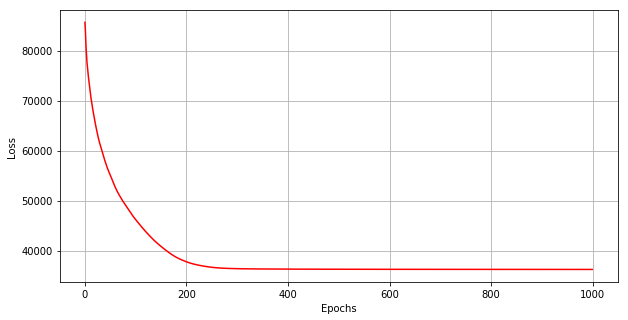

In [0]:
plt.figure(figsize=(10,5))
plt.title('')
plt.plot(err, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

### 5) Obtener las matrices $A$ y $\Pi$

In [0]:
# Para cada palabra del alfabeto, predecir el vector de probabilidades
# y agruparlos por columna para hacer la matriz A

# A = []

# for wj in Sigma[:-2]:
#     aj = predict(word2oneHot[wj])
#     A.append(list(aj))
    
# A = np.matrix(A).T

In [0]:
# El vector de inicio se obtiene al predecir la distribucion
# para el simbolo <BOS>
# Pi = predict(word2oneHot['<BOS>'])

### 6) Calcular la propabilidad de las siguientes oraciones

Se calcularan usando la propiedad de Markov que establece que:

$p(x_1,...,x_n)=\prod_{i=1}^{n}p(w_{i}|w_{i-1})$

1) Nos bañamos con agua caliente

$p(caliente|agua)p(agua|con)p(con|banamos)p(banamos|nos)p(nos|BOS)$

In [0]:
#s1 = 'Nos banamos con agua caliente'.split()
# s1 = '<BOS> pascuala ordenaba las vacas'.split()
# s1[1:] = [stemmer.stem(word.lower()) for word in s[1:]]

In [0]:
#j = word2number['las']
#i = word2number['vacas']

#A[i,j]

In [0]:
#Pi[word2number['pues']]

In [0]:
# p = 1

# for wi, wj in zip(s[:-1], s[1:]):
#     if wi == '<BOS>':
#         p *= Pi[word2number[wj]]
#     else:
#         i = word2number[wj]
#         j = word2number[wi]
#         p *= A[i,j]
        
# print('p(s) = ', p)

p(s) =  2.425589910422211e-19


2) El animalito le olía la cabeza

$p(cabeza|la)p(la|olía)p(olía|le)p(le|animalito)p(animalito|El)p(El|BOS)$

3) Pascuala ordeñaba las vacas

$p(vacas|las)p(las|ordeñaba)p(ordeñaba|Pascuala)p(Pascuala|BOS)$

In [0]:
jhyjk

jygyuguui
